# [1D-BASELINE] Exp30: No Policy Random Pan and Tilt Policy LEFT Analysis

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [3]:
import datetime
import time
from IPython.display import clear_output

## Instantiation

In [4]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/569.4456315)  #LEFT: fx = 569.4456315. fy = 571.54490033
    x = math.degrees(x)
    return x

def px_to_deg_fy(x):
    x = math.atan(x/571.54490033)  #LEFT: fx = 569.4456315. fy = 571.54490033
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "const_results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def ctr_cross_img(img):
    img = cv.line(img, (315, 0), (315, 480), (0,255,0))
    img = cv.line(img, (0, 202), (640, 202), (0,255,0))
    img = cv.drawMarker(img, (315,202), color=(0, 255, 0), markerType=cv.MARKER_CROSS, markerSize=15, thickness=2)
    return img

def get_chess_target(idx, img):
    target = get_chessboard_point(img, idx)
    delta_x = target[0]-314.69441889
    delta_x_deg = px_to_deg_fx(delta_x)
    delta_y =  201.68845842 - target[1]
    delta_y_deg = px_to_deg_fy(delta_y)
    
    print("Delta x (px)=", delta_x)
    print("Delta x (deg)=", delta_x_deg)
    print("Delta y (px)=", delta_y)
    print("Delta y (deg)=", delta_y_deg)
    
    return delta_x, delta_y

def display_target(delta_x, delta_y, img):
    abs_x = 314.69441889 + delta_x
    abs_y = 201.68845842 - delta_y
    disp_img = cv.drawMarker(img, (round(abs_x),round(abs_y)), color=(255, 0, 0), markerType=cv.MARKER_TILTED_CROSS, markerSize=13, thickness=2)
    return disp_img

def approx_reset():
    state = grace.move_left_eye((None, 0))
    grace.slow_move_left_eye_pan(angle=8.0, step_size=0.0879, time_interval=0.015)
    grace.slow_move_left_eye_pan(angle=-8.0, step_size=0.0879, time_interval=0.015)
    grace.slow_move_left_eye_pan(angle=0, step_size=0.0879, time_interval=0.015)
    pan_backlash.phi = 0.4
    tilt_policy.phi = 0
    time.sleep(0.75)
    return state

# Loading the Data

In [5]:
# Opening of Pickle File
filename = "20230603_051031_740295_left_1D-BASELINE_EXP30_NoRandPanTiltPolicy.pickle"
fn = os.path.join(os.path.abspath(".."), "const_results",filename)

In [6]:
with open(fn, 'rb') as file:
    data_load = pickle.load(file)
data = data_load['data'][0]

# Data Analysis

## Pan Histogram

In [7]:
left_left_p = [i for i in range(1,len(data["prev_theta_p"])) if data["new_theta_p"][i-1]<data["prev_theta_p"][i-1]
                and data["new_theta_p"][i]<data["prev_theta_p"][i]]
left_right_p = [i for i in range(1,len(data["prev_theta_p"])) if data["new_theta_p"][i-1]<data["prev_theta_p"][i-1] 
               and data["new_theta_p"][i]>=data["prev_theta_p"][i]]
right_left_p = [i for i in range(1,len(data["prev_theta_p"])) if data["new_theta_p"][i-1]>=data["prev_theta_p"][i-1] 
               and data["new_theta_p"][i]<data["prev_theta_p"][i]]
right_right_p = [i for i in range(1,len(data["prev_theta_p"])) if data["new_theta_p"][i-1]>=data["prev_theta_p"][i-1] 
               and data["new_theta_p"][i]>=data["prev_theta_p"][i]]

In [8]:
# Calculation

# From left to left
new_delta_x_arr1 = -1*np.array(data["new_delta_x"])[left_left_p]
err_target_deg1 = np.array([px_to_deg_fx(x) for x in new_delta_x_arr1])

# From left to right
new_delta_x_arr2 = -1*np.array(data["new_delta_x"])[left_right_p]
err_target_deg2 = np.array([px_to_deg_fx(x) for x in new_delta_x_arr2])

# From right to left
new_delta_x_arr3 = -1*np.array(data["new_delta_x"])[right_left_p]
err_target_deg3 = np.array([px_to_deg_fx(x) for x in new_delta_x_arr3])

# From right to right
new_delta_x_arr4 = -1*np.array(data["new_delta_x"])[right_right_p]
err_target_deg4 = np.array([px_to_deg_fx(x) for x in new_delta_x_arr4])

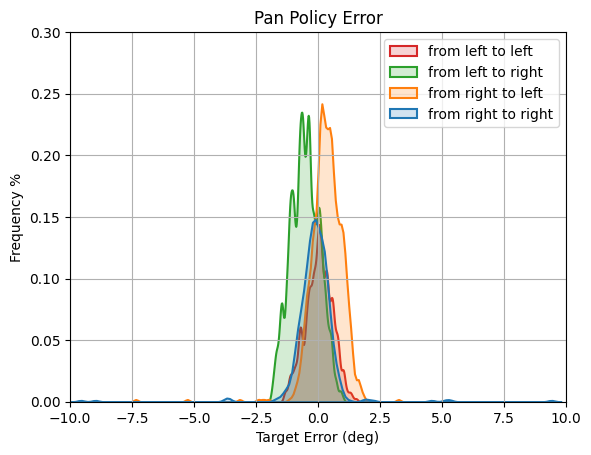

In [9]:
sns.kdeplot([err_target_deg4, err_target_deg3, err_target_deg2, err_target_deg1], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from left to left','from left to right','from right to left','from right to right'])
plt.xlim([-10,10])
plt.ylim([0,0.3])
plt.title("Pan Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

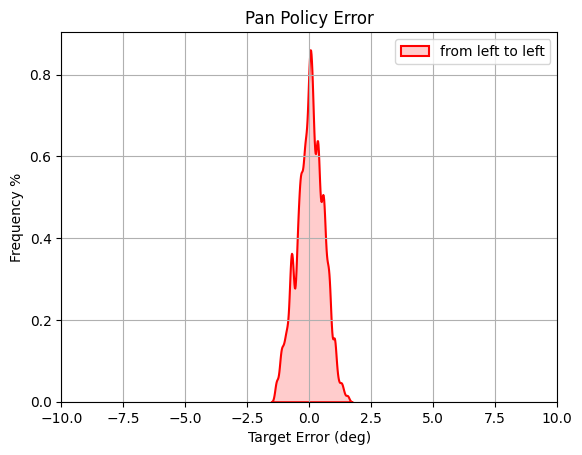

In [10]:
sns.kdeplot(err_target_deg1, color='Red' ,fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from left to left',])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Pan Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

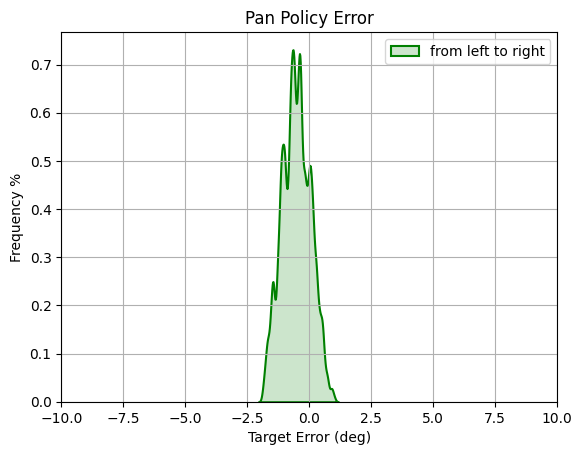

In [11]:
sns.kdeplot(err_target_deg2, color='Green' ,fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from left to right'])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Pan Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

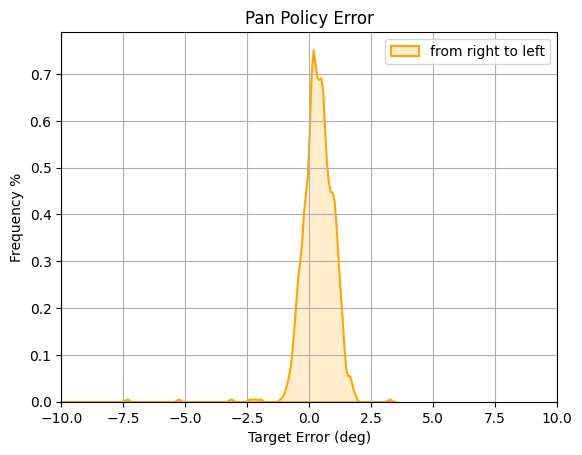

In [12]:
sns.kdeplot(err_target_deg3, color='Orange' ,fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from right to left'])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Pan Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

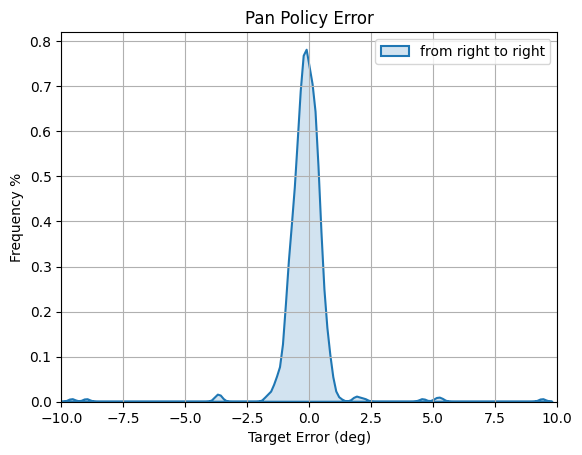

In [13]:
sns.kdeplot([err_target_deg4], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from right to right'])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Pan Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

In [14]:
 # MAE Calculation

ll_mae_px = np.sum(np.abs(new_delta_x_arr1))/len(new_delta_x_arr1)
ll_mae_deg = px_to_deg_fx(ll_mae_px)
lr_mae_px = np.sum(np.abs(new_delta_x_arr2))/len(new_delta_x_arr2)
lr_mae_deg = px_to_deg_fx(lr_mae_px)
rl_mae_px = np.sum(np.abs(new_delta_x_arr3))/len(new_delta_x_arr3)
rl_mae_deg = px_to_deg_fx(rl_mae_px)
rr_mae_px = np.sum(np.abs(new_delta_x_arr4))/len(new_delta_x_arr4)
rr_mae_deg = px_to_deg_fx(rr_mae_px)
pan_total_mae_px = np.sum(np.abs(np.array(data["new_delta_x"])))/len(data["new_delta_x"])
pan_total_mae_deg = px_to_deg_fx(pan_total_mae_px)

print(f"Left-Left MAE (px): {ll_mae_px:.4f}")
print(f"Left-Left MAE (deg): {ll_mae_deg:.4f}")
print(f"Left-Right MAE (px): {lr_mae_px:.4f}")
print(f"Left-Right MAE (deg): {lr_mae_deg:.4f}")
print(f"Right-Left MAE (px): {rl_mae_px:.4f}")
print(f"Right-Left MAE (deg): {rl_mae_deg:.4f}")
print(f"Right-Right MAE (px): {rr_mae_px:.4f}")
print(f"Right-Right MAE (deg): {rr_mae_deg:.4f}")
print(f"Total MAE (px): {pan_total_mae_px:.4f}")
print(f"Total MAE (deg): {pan_total_mae_deg:.4f}")

Left-Left MAE (px): 4.2938
Left-Left MAE (deg): 0.4320
Left-Right MAE (px): 6.4172
Left-Right MAE (deg): 0.6456
Right-Left MAE (px): 5.5715
Right-Left MAE (deg): 0.5606
Right-Right MAE (px): 5.2459
Right-Right MAE (deg): 0.5278
Total MAE (px): 5.5664
Total MAE (deg): 0.5601


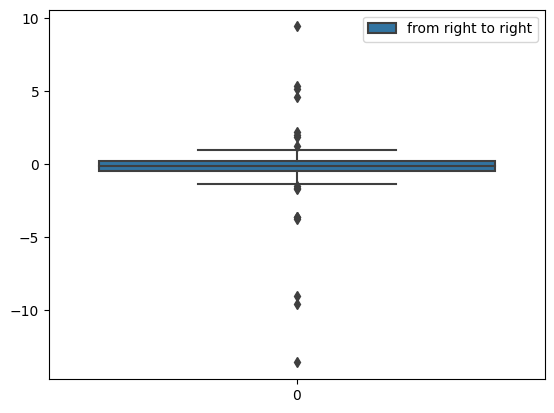

In [15]:
# Filtered Right to Right

sns.boxplot(err_target_deg4)
plt.legend(['from right to right'])

In [16]:
upper_limit = np.quantile(err_target_deg4, 0.99)
lower_limit = np.quantile(err_target_deg4, 0.01)

print('Upper Limit:', upper_limit)
print('Lower Limit:', lower_limit)

Upper Limit: 1.9440907115110908
Lower Limit: -3.3986294661426157


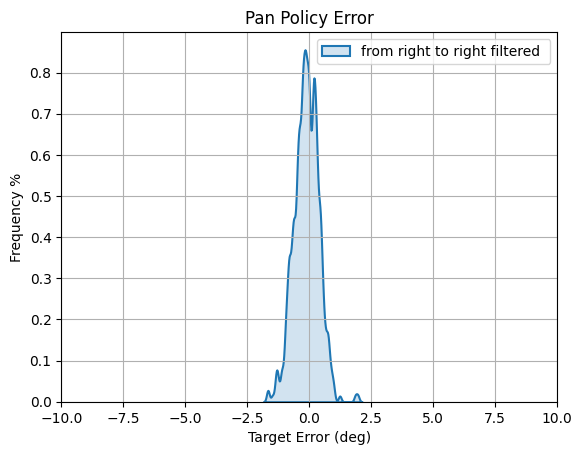

In [17]:
filt_new_delta_x_arr4 = new_delta_x_arr4[np.where(np.logical_and(new_delta_x_arr4>=-34, new_delta_x_arr4<=19.44))]
filt_err_target_deg4 = np.array([px_to_deg_fx(x) for x in filt_new_delta_x_arr4])

sns.kdeplot([filt_err_target_deg4], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from right to right filtered '])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Pan Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

In [18]:
filt_rr_mae_px = np.sum(np.abs(filt_new_delta_x_arr4))/len(filt_new_delta_x_arr4)
filt_rr_mae_deg = px_to_deg_fx(filt_rr_mae_px)
print(f"Filtered Right-Right MAE (px): {filt_rr_mae_px:.4f}")
print(f"Filtered Right-Right MAE (deg): {filt_rr_mae_deg:.4f}")

Filtered Right-Right MAE (px): 3.9665
Filtered Right-Right MAE (deg): 0.3991


## Tilt Histogram

In [19]:
down_down_t = [i for i in range(1,len(data["prev_theta_t"])) if data["new_theta_t"][i-1]<data["prev_theta_t"][i-1] 
               and data["new_theta_t"][i]<data["prev_theta_t"][i]]
down_up_t = [i for i in range(1,len(data["prev_theta_t"])) if data["new_theta_t"][i-1]<data["prev_theta_t"][i-1] 
               and data["new_theta_t"][i]>=data["prev_theta_t"][i]]
up_down_t = [i for i in range(1,len(data["prev_theta_t"])) if data["new_theta_t"][i-1]>=data["prev_theta_t"][i-1] 
               and data["new_theta_t"][i]<data["prev_theta_t"][i]]
up_up_t = [i for i in range(1,len(data["prev_theta_t"])) if data["new_theta_t"][i-1]>=data["prev_theta_t"][i-1] 
               and data["new_theta_t"][i]>=data["prev_theta_t"][i]]

In [20]:
# Calculation

# From down to down
new_delta_y_arr1 = -1*np.array(data["new_delta_y"])[down_down_t]
err_target_deg1 = np.array([px_to_deg_fy(x) for x in new_delta_y_arr1])

# From down to up
new_delta_y_arr2 = -1*np.array(data["new_delta_y"])[down_up_t]
err_target_deg2 = np.array([px_to_deg_fy(x) for x in new_delta_y_arr2])

# From up to down
new_delta_y_arr3 = -1*np.array(data["new_delta_y"])[up_down_t]
err_target_deg3 = np.array([px_to_deg_fy(x) for x in new_delta_y_arr3])

# From up to up
new_delta_y_arr4 = -1*np.array(data["new_delta_y"])[up_up_t]
err_target_deg4 = np.array([px_to_deg_fy(x) for x in new_delta_y_arr4])

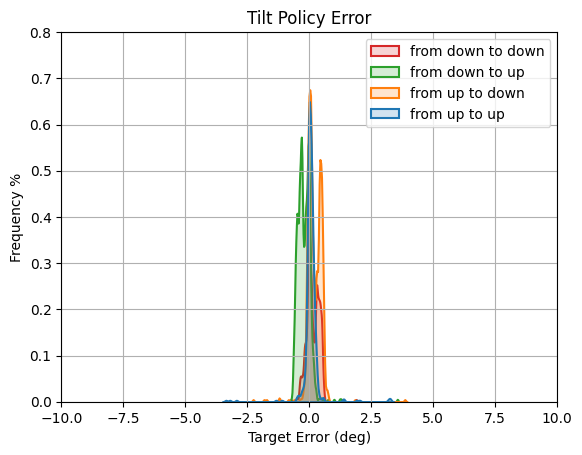

In [21]:
sns.kdeplot([err_target_deg4, err_target_deg3, err_target_deg2, err_target_deg1], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from down to down','from down to up','from up to down','from up to up',])
plt.xlim([-10,10])
plt.ylim([0,0.8])
plt.title("Tilt Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

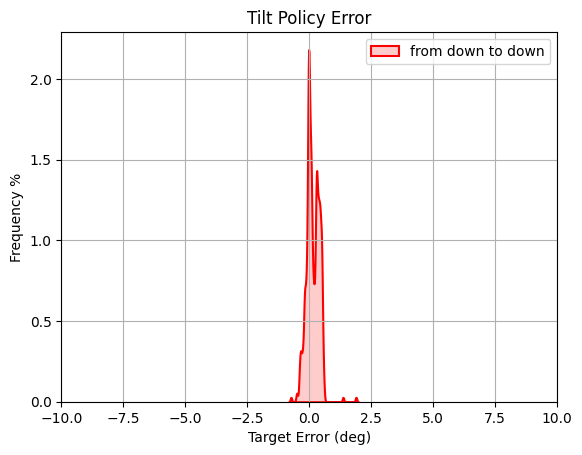

In [22]:
sns.kdeplot(err_target_deg1, color='Red' ,fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from down to down'])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Tilt Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

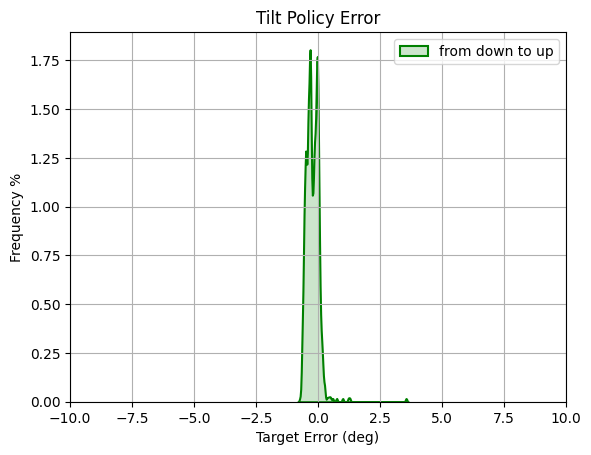

In [23]:
sns.kdeplot(err_target_deg2, color='Green' ,fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from down to up'])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Tilt Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

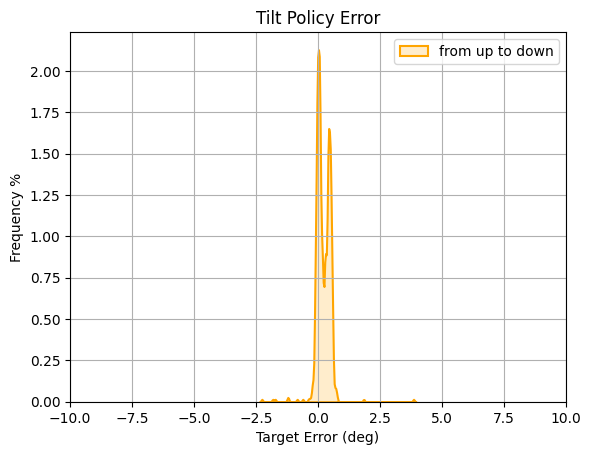

In [24]:
sns.kdeplot(err_target_deg3, color='Orange' ,fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from up to down'])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Tilt Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

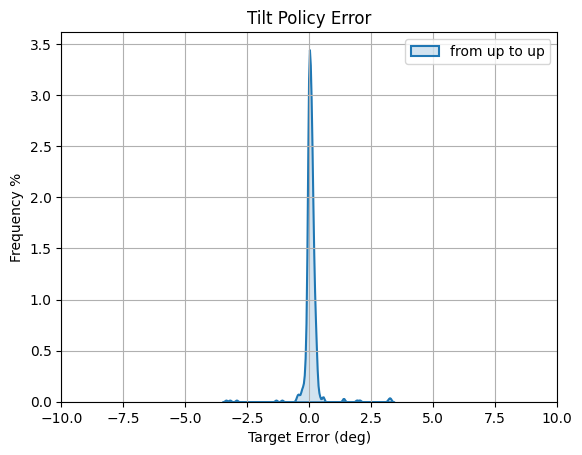

In [25]:
sns.kdeplot([err_target_deg4], fill=True,alpha=.2, linewidth=1.5, bw_adjust=0.4)
plt.legend(['from up to up'])
plt.xlim([-10,10])
# plt.ylim([0,0.3])
plt.title("Tilt Policy Error")
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')
plt.grid()

In [26]:
 # MAE Calculation

dd_mae_px = np.sum(np.abs(new_delta_y_arr1))/len(new_delta_y_arr1)
dd_mae_deg = px_to_deg_fy(dd_mae_px)
du_mae_px = np.sum(np.abs(new_delta_y_arr2))/len(new_delta_y_arr2)
du_mae_deg = px_to_deg_fy(du_mae_px)
ud_mae_px = np.sum(np.abs(new_delta_y_arr3))/len(new_delta_y_arr3)
ud_mae_deg = px_to_deg_fy(ud_mae_px)
uu_mae_px = np.sum(np.abs(new_delta_y_arr4))/len(new_delta_y_arr4)
uu_mae_deg = px_to_deg_fy(uu_mae_px)
tilt_total_mae_px = np.sum(np.abs(np.array(data["new_delta_y"])))/len(data["new_delta_y"])
tilt_total_mae_deg = px_to_deg_fy(tilt_total_mae_px)

print(f"Down-Down MAE (px): {dd_mae_px:.4f}")
print(f"Down-Down MAE (deg): {dd_mae_deg:.4f}")
print(f"Down-Up MAE (px): {du_mae_px:.4f}")
print(f"Down-Up MAE (deg): {du_mae_deg:.4f}")
print(f"Up-Down MAE (px): {ud_mae_px:.4f}")
print(f"Up-Down MAE (deg): {ud_mae_deg:.4f}")
print(f"Up-Up MAE (px): {uu_mae_px:.4f}")
print(f"Up-Up MAE (deg): {uu_mae_deg:.4f}")
print(f"Total MAE (px): {tilt_total_mae_px:.4f}")
print(f"Total MAE (deg): {tilt_total_mae_deg:.4f}")

Down-Down MAE (px): 2.2262
Down-Down MAE (deg): 0.2232
Down-Up MAE (px): 2.7277
Down-Up MAE (deg): 0.2734
Up-Down MAE (px): 2.5288
Up-Down MAE (deg): 0.2535
Up-Up MAE (px): 1.5239
Up-Up MAE (deg): 0.1528
Total MAE (px): 2.3483
Total MAE (deg): 0.2354


# Other Analysis

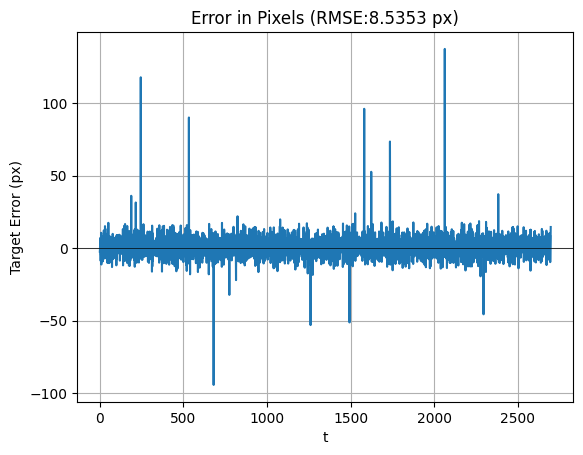

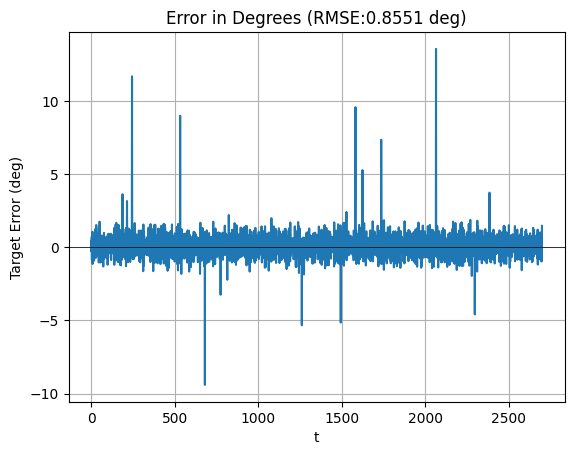

RMSE (px): 8.535321492932079
RMSE (deg): 0.8550699516893975


In [27]:
# Pan Policy

# Calculation of Error (Px)

%matplotlib inline

new_delta_x_arr = np.array(data["new_delta_x"][1:])
rmse_px = math.sqrt(np.sum(new_delta_x_arr**2)/len(new_delta_x_arr))
plt.plot(new_delta_x_arr)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.ylabel('Target Error (px)')
plt.grid()
plt.title("Error in Pixels (RMSE:%.4f px)" % (rmse_px))
plt.show()


# Calculation of Error (Deg)

err_target_deg = np.array([px_to_deg_fx(x) for x in new_delta_x_arr])
rmse_deg = math.sqrt(np.sum(err_target_deg**2)/len(new_delta_x_arr))
plt.plot(err_target_deg)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.ylabel('Target Error (deg)')
plt.grid()
plt.title("Error in Degrees (RMSE:%.4f deg)" % (rmse_deg))
plt.show()

print("RMSE (px):", rmse_px)
print("RMSE (deg):", rmse_deg)

Text(0, 0.5, 'Frequency %')

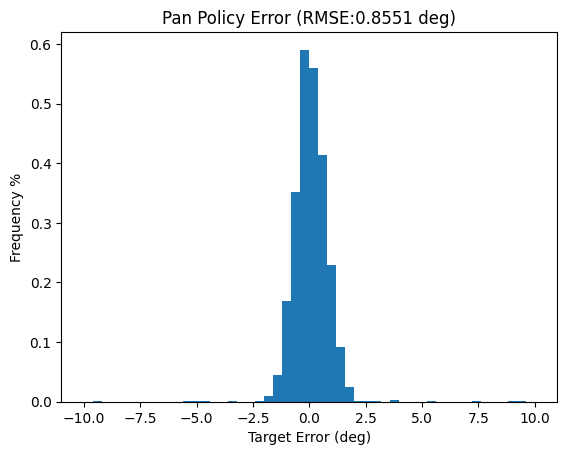

In [28]:
%matplotlib inline

plt.title("Pan Policy Error (RMSE:%.4f deg)" % (rmse_deg))
plt.hist(err_target_deg, bins=50, range=(-10,10), density=True)
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')

Text(0, 0.5, 'φ_p (deg)')

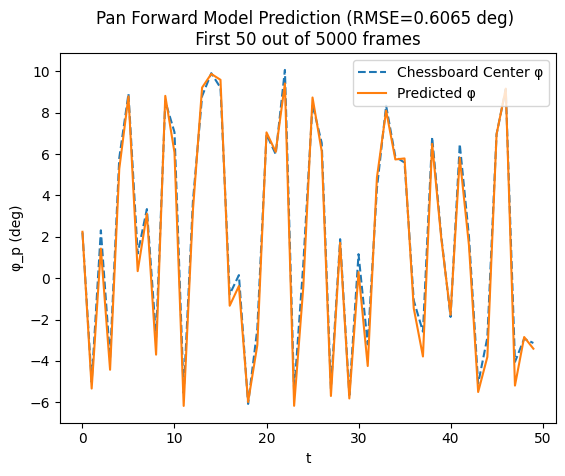

In [29]:
%matplotlib inline

# Pan Forward Model

true_phi_p = [px_to_deg_fx(317.13846547-x[0]) for x in data["new_ctr_px"]]
pred_phi_p = data["new_model_phi_p"]
rmse_phi = mean_squared_error(true_phi_p, pred_phi_p, squared=False)
plt.plot(true_phi_p[:50], linestyle='--')
plt.plot(pred_phi_p[:50])
plt.title("Pan Forward Model Prediction (RMSE=%.4f deg) \n First 50 out of 5000 frames " % (rmse_phi))
plt.legend(["Chessboard Center φ", "Predicted φ"])
plt.xlabel("t")
plt.ylabel("φ_p (deg)")

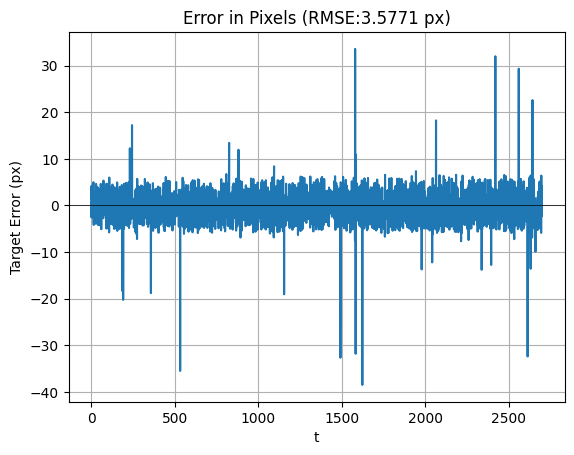

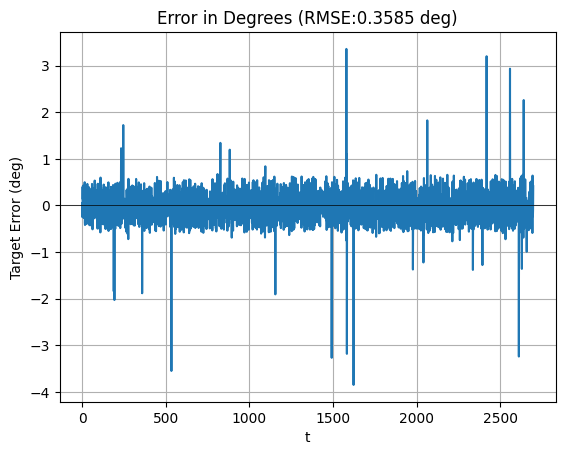

RMSE (px): 3.577073303665043
RMSE (deg): 0.35846683039516014


In [31]:
# Tilt Policy

# Calculation of Error (Px)

%matplotlib inline

new_delta_y_arr = np.array(data["new_delta_y"][1:])
rmse_px = math.sqrt(np.sum(new_delta_y_arr**2)/len(new_delta_y_arr))
plt.plot(new_delta_y_arr)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.ylabel('Target Error (px)')
plt.grid()
plt.title("Error in Pixels (RMSE:%.4f px)" % (rmse_px))
plt.show()


# Calculation of Error (Deg)

err_target_deg = np.array([px_to_deg_fy(x) for x in new_delta_y_arr])
rmse_deg = math.sqrt(np.sum(err_target_deg**2)/len(new_delta_y_arr))
plt.plot(err_target_deg)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.ylabel('Target Error (deg)')
plt.grid()
plt.title("Error in Degrees (RMSE:%.4f deg)" % (rmse_deg))
plt.show()

print("RMSE (px):", rmse_px)
print("RMSE (deg):", rmse_deg)

Text(0, 0.5, 'Frequency %')

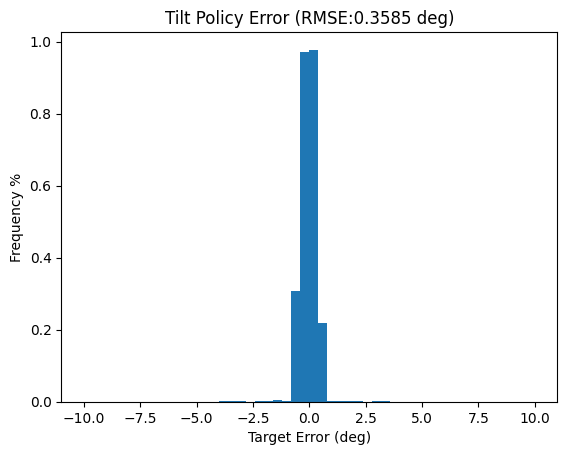

In [32]:
plt.title("Tilt Policy Error (RMSE:%.4f deg)" % (rmse_deg))
plt.hist(err_target_deg, bins=50, range=(-10,10), density=True)
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')

Text(0, 0.5, 'φ_t (deg)')

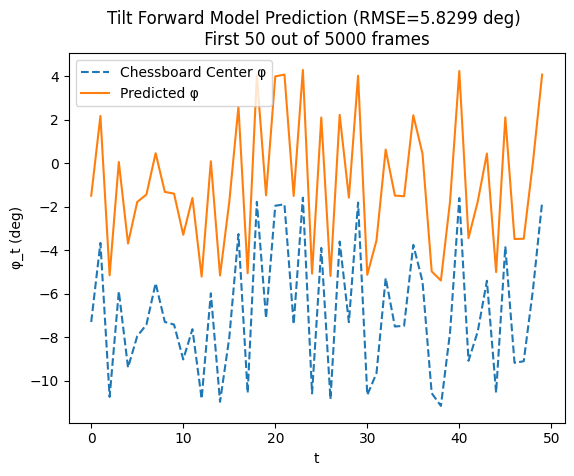

In [33]:
# Tilt Forward Model

true_phi_t = [px_to_deg_fx(x[1]-219.22972847) for x in data["new_ctr_px"]]
pred_phi_t = data["new_model_phi_t"]
rmse_phi = mean_squared_error(true_phi_t, pred_phi_t, squared=False)
plt.plot(true_phi_t[:50], linestyle='--')
plt.plot(pred_phi_t[:50])
plt.title("Tilt Forward Model Prediction (RMSE=%.4f deg) \n First 50 out of 5000 frames " % (rmse_phi))
plt.legend(["Chessboard Center φ", "Predicted φ"])
plt.xlabel("t")
plt.ylabel("φ_t (deg)")

In [34]:
# Looping for Policy Plot

# Data
delta_x_list = []
delta_y_list = []
for chess_idx in range(54):
    idxs = [i for i,val in enumerate(data["chess_idx"]) if val==chess_idx]
    after_px_x = np.array([data["new_delta_x"][i] for i in idxs])
    after_px_y = np.array([data["new_delta_y"][i] for i in idxs])
    delta_x_list.append(after_px_x)
    delta_y_list.append(after_px_y)

(-25.0, 125.0)

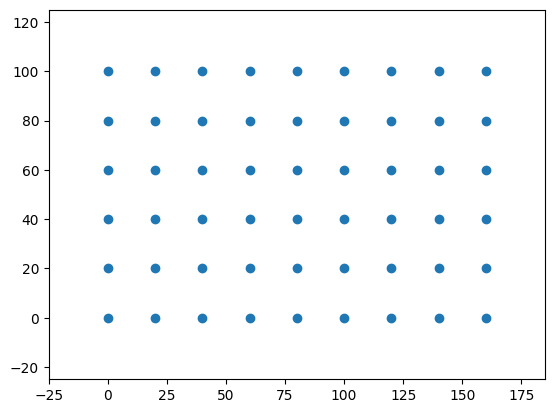

In [35]:
chess_x, chess_y = np.meshgrid(np.linspace(0,160, 9), np.linspace(100, 0, 6))
plt.scatter(chess_x, chess_y)
plt.xlim([-25, 185])
plt.ylim([-25, 125])

In [36]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

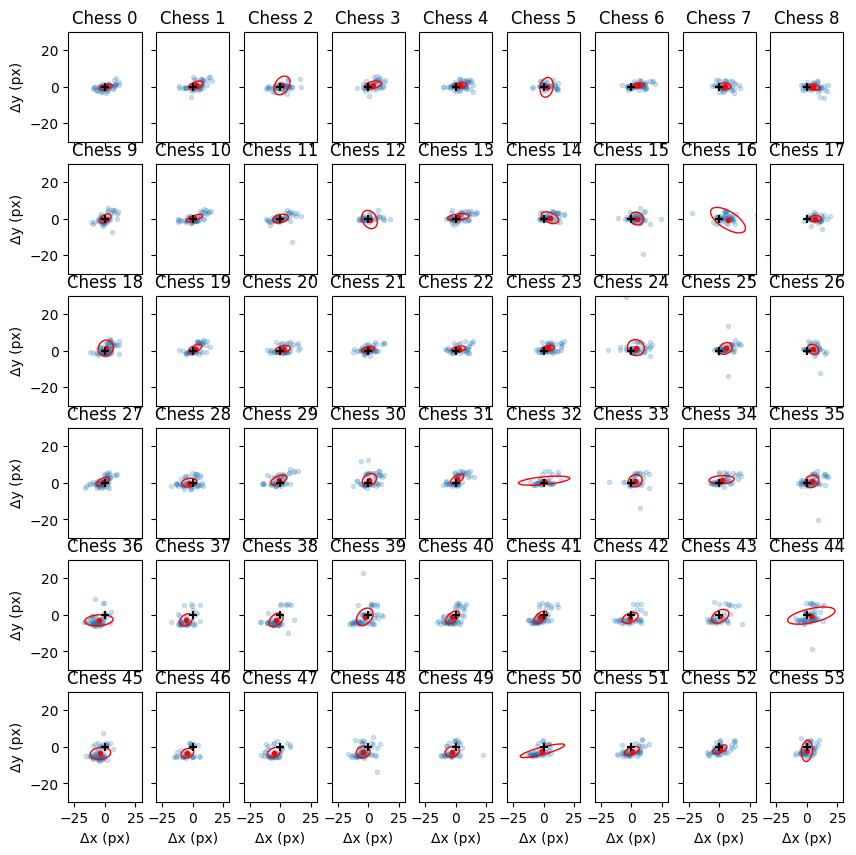

In [37]:
# Scatter Plot

%matplotlib inline
fig, axs = plt.subplots(6, 9, figsize=(10,10))
for i,ax_i in enumerate(axs.flat):
    ax_i.scatter(delta_x_list[i], delta_y_list[i], marker='.', color='#1f77b4', alpha=0.2)
    confidence_ellipse(x=delta_x_list[i], y=delta_y_list[i], ax=ax_i, n_std=1.0, edgecolor='red')
    ax_i.scatter(delta_x_list[i].mean(), delta_y_list[i].mean(), marker='.', color='red')
    ax_i.scatter(0, 0, marker='+', color='black')
    ax_i.set_xlim(-30, 30)
    ax_i.set_ylim(-30, 30)
    ax_i.set_title('Chess %i' % (i))

for ax in axs.flat:
    ax.set(xlabel='Δx (px)', ylabel='Δy (px)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
%matplotlib inline

# Ellipse Plot
fig, ax_plt = plt.subplots(figsize=(10,10))
for i in range(6):
    for j in range(9):
        confidence_ellipse(x=chess_x[i,j] + delta_x_list[i*6+j], y=chess_y[i,j] + delta_y_list[i*6+j], ax=ax_plt, n_std=1.0, edgecolor='red')
        ax_plt.scatter(chess_x[i,j]+delta_x_list[i*6+j].mean(), y=chess_y[i,j] + delta_y_list[i*6+j].mean(), marker='.', s=50, color='red')

# Chess Plane
ax_plt.scatter(chess_x, chess_y, marker='+', s=100)    
    
ax_plt.set_xlim([-90, 250])
ax_plt.set_ylim([-25, 125])

labels = [item.get_text() for item in ax_plt.get_yticklabels()]
labels = [' ',' ', '6', '5', '4', '3', '2', '1' ,'']
ax_plt.set_yticklabels(labels)

ax_plt.set_xticks(np.arange(0, 180, 20))
labels = [item.get_text() for item in ax_plt.get_xticklabels()]
labels = ['1','2', '3', '4', '5', '6', '7', '8' ,'9']
ax_plt.set_xticks(np.arange(0, 180, 20))
ax_plt.set_xticklabels(labels)

ax_plt.set_xlabel('Chessboard Columns')
ax_plt.set_ylabel('Chessboard Rows')
